In [1]:
import pandas
import numpy as np
# import map_funcs
import sys

global tfrz
global rgas
tfrz = 273.15
rgas = 8314.4598

### temperature functions for scaling vcmax and jmax to temperatures
def ft1_f(tl, ha):
    # from FATES code
    # !
    # !!DESCRIPTION:
    # ! photosynthesis temperature response
    # !
    # ! !ARGUMENTS:
    # real(r8), intent(in) :: tl  ! leaf temperature in photosynthesis temperature function (K)
    # real(r8), intent(in) :: ha  ! activation energy in photosynthesis temperature function (J/mol)
    #
    ans = np.exp( ha / (rgas*1.e-3*(tfrz+25.)) * (1. - (tfrz+25.)/tl) )
    #
    return ans

def fth_f(tl,hd,se,scaleFactor):
    # From FATES code
    # !
    # !!DESCRIPTION:
    # !photosynthesis temperature inhibition
    # !
    # ! !ARGUMENTS:
    # real(r8), intent(in) :: tl  ! leaf temperature in photosynthesis temp function (K)
    # real(r8), intent(in) :: hd  ! deactivation energy in photosynthesis temp function (J/mol)
    # real(r8), intent(in) :: se  ! entropy term in photosynthesis temp function (J/mol/K)
    # real(r8), intent(in) :: scaleFactor  ! scaling factor for high temp inhibition (25 C = 1.0)
    #
    ans = scaleFactor / ( 1. + np.exp( (-hd+se*tl) / (rgas*1.e-3*tl) ) )
    #
    return ans

def fth25_f(hd,se):
    # From FATES code
    # !
    # !!DESCRIPTION:
    # ! scaling factor for photosynthesis temperature inhibition
    # !
    # ! !ARGUMENTS:
    # real(r8), intent(in) :: hd    ! deactivation energy in photosynthesis temp function (J/mol)
    # real(r8), intent(in) :: se    ! entropy term in photosynthesis temp function (J/mol/K)
    #
    ans = 1. + np.exp( (-hd+se*(tfrz+25.)) / (rgas*1.e-3*(tfrz+25.)) )
    #
    return ans

wright_bci_traits_filename = 'traits_data/Wright/BCITRAITS_20101220.xls'
wright_bci_traits_file = pandas.read_excel(wright_bci_traits_filename)
wright_bci_traits_file.columns = wright_bci_traits_file.columns.str.replace('$', '')
wright_bci_specieslist = wright_bci_traits_file.loc[:].GENUS + ' ' + wright_bci_traits_file.loc[:].SPECIES
wright_bci_wooddensity1 = np.ma.masked_invalid(np.ma.asarray(wright_bci_traits_file.loc[:].SG100C_AVG))
wright_bci_wooddensity2 = np.ma.masked_invalid(np.ma.asarray(wright_bci_traits_file.loc[:].WSG_CHAVE))
wright_bci_wooddensity = np.ma.column_stack((wright_bci_wooddensity1,wright_bci_wooddensity2)).mean(axis=1)
wright_bci_mortality10cm = np.ma.masked_invalid(np.ma.asarray(wright_bci_traits_file.loc[:].MORT_100))
wright_bci_lma = np.ma.masked_invalid(np.ma.asarray(wright_bci_traits_file.loc[:].LMALEAF_AVD))

# map_funcs.xyplot(wright_bci_wooddensity,wright_bci_lma, dots=True, file='lma_vs_wooddensity', xtitle='wood density', ytitle='LMA')




### ingest Rogers et al. Leaf vcmax data
rogers_panama_vcmax_filename = 'traits_data/Rogers/2016ENSO_Panama_Fitted_Vcmax_Jmax.xlsx'
rogers_panama_vcmax_file = pandas.read_excel(rogers_panama_vcmax_filename, sheet_name=1)
nrows_rogers_vcmax_file = rogers_panama_vcmax_file.shape[0]

### open table linking species codes to species names from Rogers dataset
rogers_sepciestable_filename = 'traits_data/Rogers/species_code_table.xlsx'
rogers_sepciestable_file = pandas.read_excel(rogers_sepciestable_filename)
rogers_sepciestable_codes = rogers_sepciestable_file.Species_Code[:]
rogers_sepciestable_names = rogers_sepciestable_file.Species_Name[:]
rogers_sepciestable_codes_list = list(rogers_sepciestable_codes)

# create a mapping array that allows us to group observations by species
species_code_list_rogers_vcmaxfile = []
species_name_list_rogers_vcmaxfile = []
species_list_rogers_vcmaxfile_index = np.ma.masked_all(nrows_rogers_vcmax_file)
for i in range(nrows_rogers_vcmax_file):
    species = rogers_panama_vcmax_file.Species[i]
    if not species in species_code_list_rogers_vcmaxfile:
        species_code_list_rogers_vcmaxfile.append(species)
        if species in rogers_sepciestable_codes_list:
            species_name_list_rogers_vcmaxfile.append(rogers_sepciestable_names[rogers_sepciestable_codes_list.index(species)])
        else:
            print(' no species name for code '+species)
            species_name_list_rogers_vcmaxfile.append(species)
    species_list_rogers_vcmaxfile_index[i] = species_code_list_rogers_vcmaxfile.index(species)

nspecies = len(species_code_list_rogers_vcmaxfile)

mean_species_vcmax25 = np.ma.masked_all(nspecies)
#mean_species_vcmax = np.ma.masked_all(nspecies)

### we need temperature scaling factors to get from vcmax to vcmax25
vcmaxha = 65330
vcmaxhd = 149250
vcmaxse = 485
vcmaxc = fth25_f(vcmaxhd, vcmaxse)

# get rid of dots in column header names
rogers_panama_vcmax_file.columns = rogers_panama_vcmax_file.columns.str.replace('.', '')

# sanity check on vcmax temperature scaling
# tleaf = np.linspace(0.,35.,100)
# scalar = (ft1_f(tleaf+tfrz, vcmaxha) * fth_f(tleaf+tfrz, vcmaxhd, vcmaxse, vcmaxc))
# # map_funcs.xyplot(tleaf, scalar)

for i in range(nspecies):
    # extract leaf temeprature and put in K
    veg_tempk = tfrz + np.ma.masked_array(rogers_panama_vcmax_file.MeanTleaf[:], mask = species_list_rogers_vcmaxfile_index != i)
    vcmax25 = np.ma.masked_array(rogers_panama_vcmax_file.Vcmax[:], mask = species_list_rogers_vcmaxfile_index != i) / (ft1_f(veg_tempk, vcmaxha) * fth_f(veg_tempk, vcmaxhd, vcmaxse, vcmaxc))
    mean_species_vcmax25[i] = vcmax25.mean()
    # mean_species_vcmax[i] = np.ma.masked_array(rogers_panama_vcmax_file.Vcmax[:], mask = species_list_rogers_vcmaxfile_index != i).mean()



# ### Ingest Rogers et al LMA data:
# ### actually lets not use these, as they are only for four species...
# rogers_slz_lma_filename = 'traits_data/Rogers/2017_SLZ_LMA_ByAge.xlsx'
# rogers_slz_lma_file = pandas.read_excel(rogers_slz_lma_filename, sheet_name=2)
# nrows_rogers_slz_lma_file = rogers_slz_lma_file.shape[0]
# # create a mapping array that allows us to group observations by species
# species_list_rogers_slafile = []
# species_list_rogers_slafile_index = np.ma.masked_all(nrows_rogers_slz_lma_file)
# for i in range(nrows_rogers_slz_lma_file):
#     species = rogers_slz_lma_file.Species[i]
#     if not species in species_list_rogers_slafile:
#         species_list_rogers_slafile.append(species)
#     species_list_rogers_slafile_index[i] = species_list_rogers_slafile.index(species)

    
### ingest Norby et al leaf vcmax data
norby_panama_leaftraits_file = 'traits_data/Norby/Panama_post.xlsx'
norby_panama_leaftraits = pandas.read_excel(norby_panama_leaftraits_file)
norby_panama_leaftraits.columns = norby_panama_leaftraits.columns.str.replace(' ', '')
nrows_norby_panama_leaftraits = norby_panama_leaftraits.shape[0] -1 # ignore the last row of this because they put units in it
norby_panama_vcmax = np.ma.masked_invalid(np.ma.masked_array(norby_panama_leaftraits.Vcmax25[0:nrows_norby_panama_leaftraits], dtype=np.float32))
norby_panama_lma = np.ma.masked_invalid(np.ma.masked_array(norby_panama_leaftraits.LMA[0:nrows_norby_panama_leaftraits], dtype=np.float32))
norby_panama_nmass = np.ma.masked_invalid(np.ma.masked_array(norby_panama_leaftraits.Nmass[0:nrows_norby_panama_leaftraits], dtype=np.float32))
norby_panama_wooddens = np.ma.masked_invalid(np.ma.masked_array(norby_panama_leaftraits.wooddensity[0:nrows_norby_panama_leaftraits], dtype=np.float32))
norby_panama_specieslist = norby_panama_leaftraits.Species

# map_funcs.xyplot(1.e-3 * norby_panama_nmass * norby_panama_lma, norby_panama_vcmax, dots=True, xtitle='N per unit area (mg N / m~S~2~N~)', ytitle='Vcmax25')
# map_funcs.xyplot(norby_panama_nmass , norby_panama_vcmax, dots=True, xtitle='N per unit mass', ytitle='Vcmax25')
# map_funcs.xyplot(norby_panama_nmass , norby_panama_vcmax, dots=True, xtitle='N per unit mass', ytitle='Vcmax25')
# map_funcs.xyplot(norby_panama_lma, norby_panama_vcmax, dots=True, xtitle='wood density', ytitle='Vcmax25', regress=True)


### ingest Wright et al leaf traits database for wet and dry forests
wright_pnm_slz_leaf_traits_filename = 'traits_data/Wright/LFTRAITS.xlsx'
wright_pnm_slz_leaf_traits_file = pandas.read_excel(wright_pnm_slz_leaf_traits_filename)
wright_pnm_slz_leaf_traits_file.columns = wright_pnm_slz_leaf_traits_file.columns.str.replace('$', '')
wright_pnm_slz_speciescodelist = wright_pnm_slz_leaf_traits_file.SP4
wright_pnm_slz_specieslist = wright_pnm_slz_leaf_traits_file.GENUS + ' ' + wright_pnm_slz_leaf_traits_file.SPECIES
wright_pnm_slz_strata = wright_pnm_slz_leaf_traits_file.STRATA
wright_pnm_slz_iscanopy = np.array(wright_pnm_slz_strata == 'CANOPY', dtype=np.bool)
wright_pnm_slz_lifeform6 = wright_pnm_slz_leaf_traits_file.LIFEFORM6
wright_pnm_slz_istree = np.array(wright_pnm_slz_lifeform6 == 'TREE', dtype=np.bool)
wright_pnm_slz_lifetime = np.ma.masked_invalid(wright_pnm_slz_leaf_traits_file.LIFETIME)
wright_pnm_slz_sla = np.ma.masked_invalid(wright_pnm_slz_leaf_traits_file.SLA_LEAF)
wright_pnm_slz_lma = np.ma.masked_invalid(wright_pnm_slz_leaf_traits_file.LMA)
wright_pnm_slz_npct = np.ma.masked_invalid(wright_pnm_slz_leaf_traits_file.N_PCT)

# map_funcs.xyplot(wright_pnm_slz_lma, wright_pnm_slz_lifetime, dots=True)


## now start to put together the various datasets

master_species_list = []
master_LMA_list = []
master_Narea_list = []
master_wood_density_list = []
master_leaf_lifespan_list = []
master_vcmax25_list = []
master_mortality10cm_list = []


## start with Wright et al., wet/dry forest data
for i in range(len(wright_pnm_slz_specieslist)):
    if wright_pnm_slz_iscanopy[i] and wright_pnm_slz_istree[i]:
        if not wright_pnm_slz_specieslist[i] in master_species_list:
            master_species_list.append(wright_pnm_slz_specieslist[i])
            master_LMA_list.append([])
            master_Narea_list.append([])
            master_wood_density_list.append([])
            master_leaf_lifespan_list.append([])
            master_vcmax25_list.append([])
            master_mortality10cm_list.append([])
        indx = master_species_list.index(wright_pnm_slz_specieslist[i])
        if wright_pnm_slz_lma.mask[i] == False:
            master_LMA_list[indx].append(wright_pnm_slz_lma[i])
        if wright_pnm_slz_lifetime.mask[i] == False:
            master_leaf_lifespan_list[indx].append(wright_pnm_slz_lifetime[i])
        if wright_pnm_slz_npct.mask[i] == False:
            master_Narea_list[indx].append(wright_pnm_slz_npct[i] * .01 * wright_pnm_slz_lma[i])

## next add the wright BCI data
for i in range(len(wright_bci_specieslist)):
    if not wright_bci_specieslist[i] in master_species_list:
        master_species_list.append(wright_bci_specieslist[i])
        master_LMA_list.append([])
        master_Narea_list.append([])
        master_wood_density_list.append([])
        master_leaf_lifespan_list.append([])
        master_vcmax25_list.append([])
        master_mortality10cm_list.append([])
    indx = master_species_list.index(wright_bci_specieslist[i])
    if wright_bci_wooddensity.mask[i] == False:
        master_wood_density_list[indx].append(wright_bci_wooddensity[i])
    if wright_bci_lma.mask[i] == False:
        master_LMA_list[indx].append(wright_bci_lma[i])
    if wright_bci_mortality10cm.mask[i] == False:
        master_mortality10cm_list[indx].append(wright_bci_mortality10cm[i])

## next add the Rogers data
for i in range(len(species_name_list_rogers_vcmaxfile)):
    if not species_name_list_rogers_vcmaxfile[i] in master_species_list:
        master_species_list.append(species_name_list_rogers_vcmaxfile[i])
        master_LMA_list.append([])
        master_Narea_list.append([])
        master_wood_density_list.append([])
        master_leaf_lifespan_list.append([])
        master_vcmax25_list.append([])
        master_mortality10cm_list.append([])
    indx = master_species_list.index(species_name_list_rogers_vcmaxfile[i])
    if mean_species_vcmax25.mask[i] == False:
        master_vcmax25_list[indx].append(mean_species_vcmax25[i])

## next add the Norby data
for i in range(len(norby_panama_specieslist)-1):  ### they used nan to encode a phantom last species name
    if not norby_panama_specieslist[i] in master_species_list:
        master_species_list.append(norby_panama_specieslist[i])
        master_LMA_list.append([])
        master_Narea_list.append([])
        master_wood_density_list.append([])
        master_leaf_lifespan_list.append([])
        master_vcmax25_list.append([])
        master_mortality10cm_list.append([])
    indx = master_species_list.index(norby_panama_specieslist[i])
    if norby_panama_vcmax.mask[i] == False:
        master_vcmax25_list[indx].append(norby_panama_vcmax[i])
    if norby_panama_lma.mask[i] == False:
        master_LMA_list[indx].append(norby_panama_lma[i])
    if norby_panama_nmass.mask[i] == False:
        master_Narea_list[indx].append(norby_panama_nmass[i] * .001 * norby_panama_lma[i])
    if norby_panama_wooddens.mask[i] == False:
        master_wood_density_list[indx].append(norby_panama_wooddens[i])

### there are a couple artifacts to sort out still: 'Apeiba membranaceae' vs 'Apeiba membranacea'; 'Cojoba rufescens ' vs 'Cojoba rufescens', etc...
nspecies_master = len(master_species_list)
master_LMA_array = np.ma.masked_all(nspecies_master)
master_Narea_array = np.ma.masked_all(nspecies_master)
master_wood_density_array = np.ma.masked_all(nspecies_master)
master_leaf_lifespan_array = np.ma.masked_all(nspecies_master)
master_vcmax25_array = np.ma.masked_all(nspecies_master)
master_mort10cm_array = np.ma.masked_all(nspecies_master)
for i in range(nspecies_master):
    if len(master_vcmax25_list[i]) > 0:
        master_vcmax25_array[i] = np.ma.masked_invalid(np.asarray(master_vcmax25_list[i]).mean()).flatten()
    if len(master_wood_density_list[i]) > 0:
        master_wood_density_array[i] = np.ma.masked_invalid(np.asarray(master_wood_density_list[i]).mean()).flatten()
    if len(master_LMA_list[i]) > 0:
        master_LMA_array[i] = np.ma.masked_invalid(np.asarray(master_LMA_list[i]).mean()).flatten()
    if len(master_Narea_list[i]) > 0:
        master_Narea_array[i] = np.ma.masked_invalid(np.asarray(master_Narea_list[i]).mean()).flatten()
    if len(master_leaf_lifespan_list[i]) > 0:
        master_leaf_lifespan_array[i] = np.ma.masked_invalid(np.asarray(master_leaf_lifespan_list[i]).mean()).flatten()     
    if len(master_mortality10cm_list[i]) > 0:
        master_mort10cm_array[i] = np.ma.masked_invalid(np.asarray(master_mortality10cm_list[i]).mean()).flatten()     


master_LMA_array = master_LMA_array.flatten()
master_Narea_array = master_Narea_array.flatten()
master_wood_density_array = master_wood_density_array.flatten()
master_leaf_lifespan_array = master_leaf_lifespan_array.flatten()
master_vcmax25_array = master_vcmax25_array.flatten()
master_mort10cm_array = master_mort10cm_array.flatten()


# map_funcs.xyplot(master_LMA_array, master_leaf_lifespan_array, dots=True, xtitle='LMA', ytitle='leaf lifespan')
# map_funcs.xyplot(master_Narea_array, master_vcmax25_array, dots=True, xtitle='N per unit area', ytitle='vcmax')
# map_funcs.xyplot(master_wood_density_array, master_vcmax25_array, dots=True, xtitle='wood density', ytitle='vcmax')
# map_funcs.xyplot(master_wood_density_array, master_LMA_array, dots=True, xtitle='wood density', ytitle='LMA')


traits_matrix = np.ma.column_stack([master_vcmax25_array,master_wood_density_array,master_LMA_array,master_Narea_array,master_leaf_lifespan_array,master_mort10cm_array])
traits_matrix = np.ma.masked_invalid(traits_matrix)


column_names = ['Vcmax25', 'wood_density', 'LMA', 'N/area','lifespan','mortality']
df = pandas.DataFrame(traits_matrix, columns=column_names)


*** No CODEPAGE record, no encoding_override: will use 'ascii'
 no species name for code CECRSP


/Users/cdkoven/miniconda2/lib/python2.7/site-packages/numpy/core/numeric.py:492: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [2]:
trait_cov = df.cov()
trait_cov

,Vcmax25,wood_density,LMA,N/area,lifespan,mortality
Vcmax25,616.837563,-1.427442,399.679850,9.308902,-2275.126519,-0.468932
wood_density,-1.427442,0.021709,0.734569,-0.019823,4.561589,-0.105272
LMA,399.679850,0.734569,952.394759,15.044990,1591.950432,-13.539449
N/area,9.308902,-0.019823,15.044990,0.352939,-11.232024,0.027366
lifespan,-2275.126519,4.561589,1591.950432,-11.232024,23903.460405,1.238443
mortality,-0.468932,-0.105272,-13.539449,0.027366,1.238443,10.267118


In [3]:
pandas.plotting.scatter_matrix(df, alpha=0.7, figsize=(15, 15), diagonal='hist')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1165ef690>,
      dtype=object)

/Users/cdkoven/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1193877d0>,
      dtype=object)

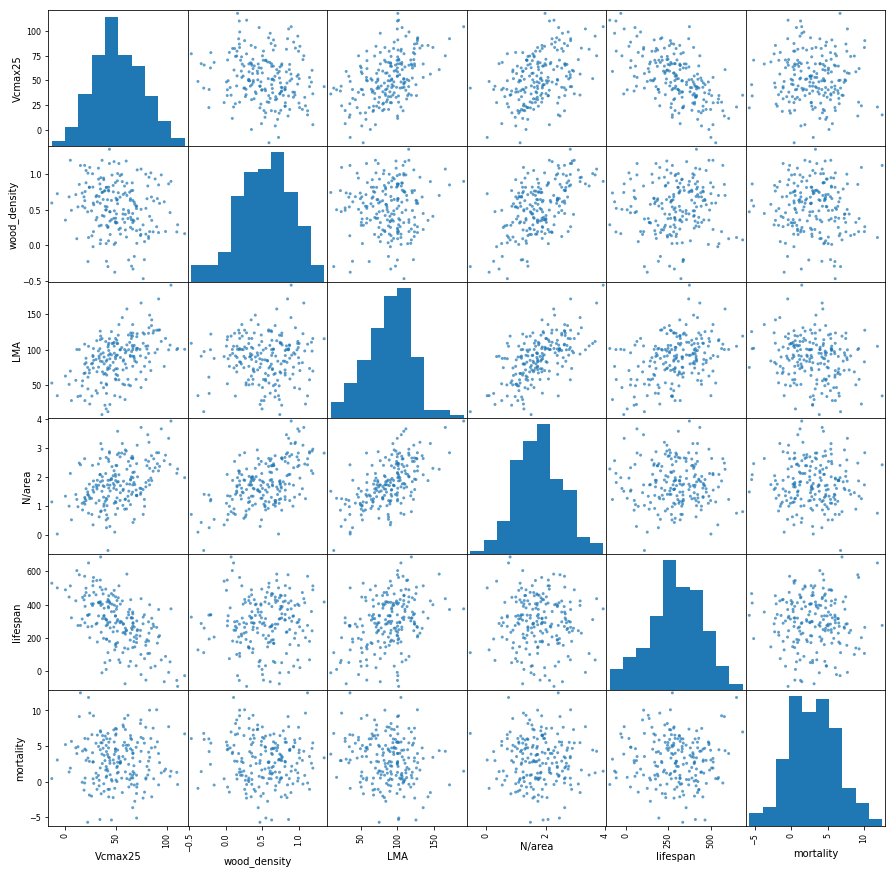

In [5]:
### because of the large amount of missing data in the above, sample as a random draw from the trait
### covariance matrix instead, so that we can generate a large number of trait values to use for a FATES ensemble.

n_out = 200
means = traits_matrix.mean(axis=0)
randomstate = np.random.RandomState(11)
X = randomstate.multivariate_normal(means, np.array(trait_cov), n_out)
df2 = pandas.DataFrame(X, columns=column_names)
pandas.plotting.scatter_matrix(df2, alpha=0.7, figsize=(15, 15), diagonal='hist')

/Users/cdkoven/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a5a9890>,
      dtype=object)

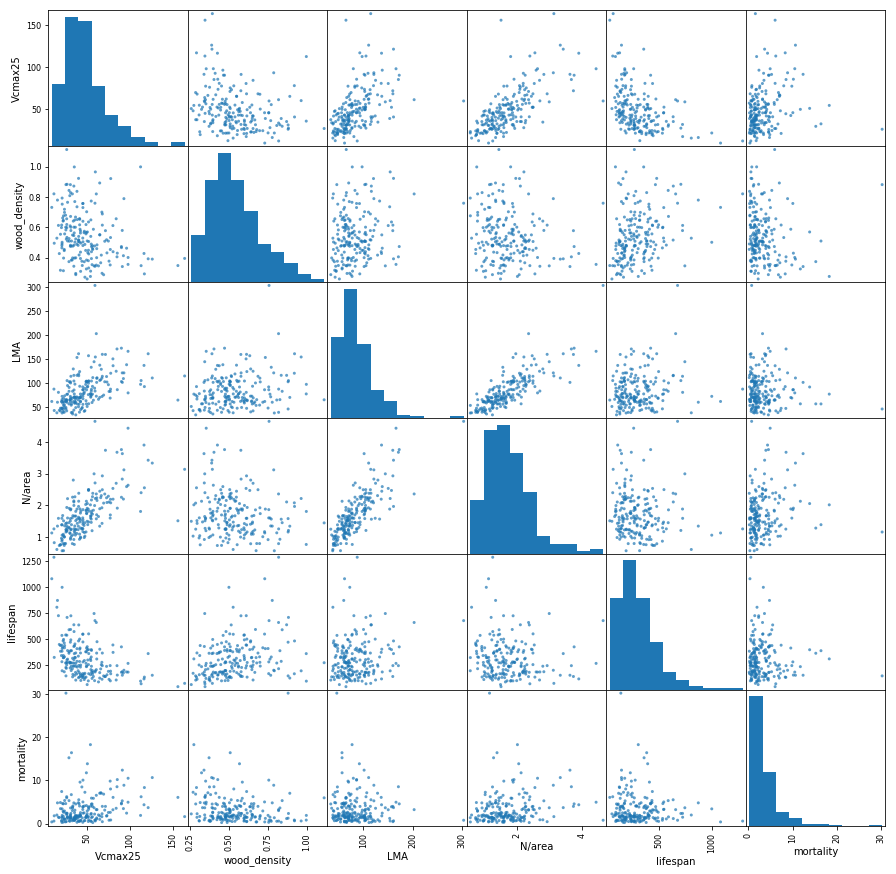

In [7]:
### instead of doing the above on raw trait data, do it on log-transformed trait data

log_traits_matrix = np.ma.log(traits_matrix)
log_cov = np.ma.cov(log_traits_matrix.transpose())
log_means = log_traits_matrix.mean(axis=0)
X_log = np.exp(randomstate.multivariate_normal(log_means, np.array(log_cov), n_out))
df3 = pandas.DataFrame(X_log, columns=column_names)
pandas.plotting.scatter_matrix(df3, alpha=0.7, figsize=(15, 15), diagonal='hist')

In [8]:
## for now we aren't doing this step.

### let crown area : DBH relationship be a function 
### of wood density following martinez-cano allometry
### CD = a DBH ^ b
### where b = 0.655 + 0.035 * z
### and log a = -0.268 + 0.186 * z
### when z is wood density
### but we want crown area = pi * (CD / 2)^2
#z = X[:,1]
#
#b = 2 * (0.655 + 0.035 * z)
#print(b)



/Users/cdkoven/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: covariance is not positive-semidefinite.
/Users/cdkoven/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: covariance is not positive-semidefinite.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11bfc0e10>,
      dtype=object)

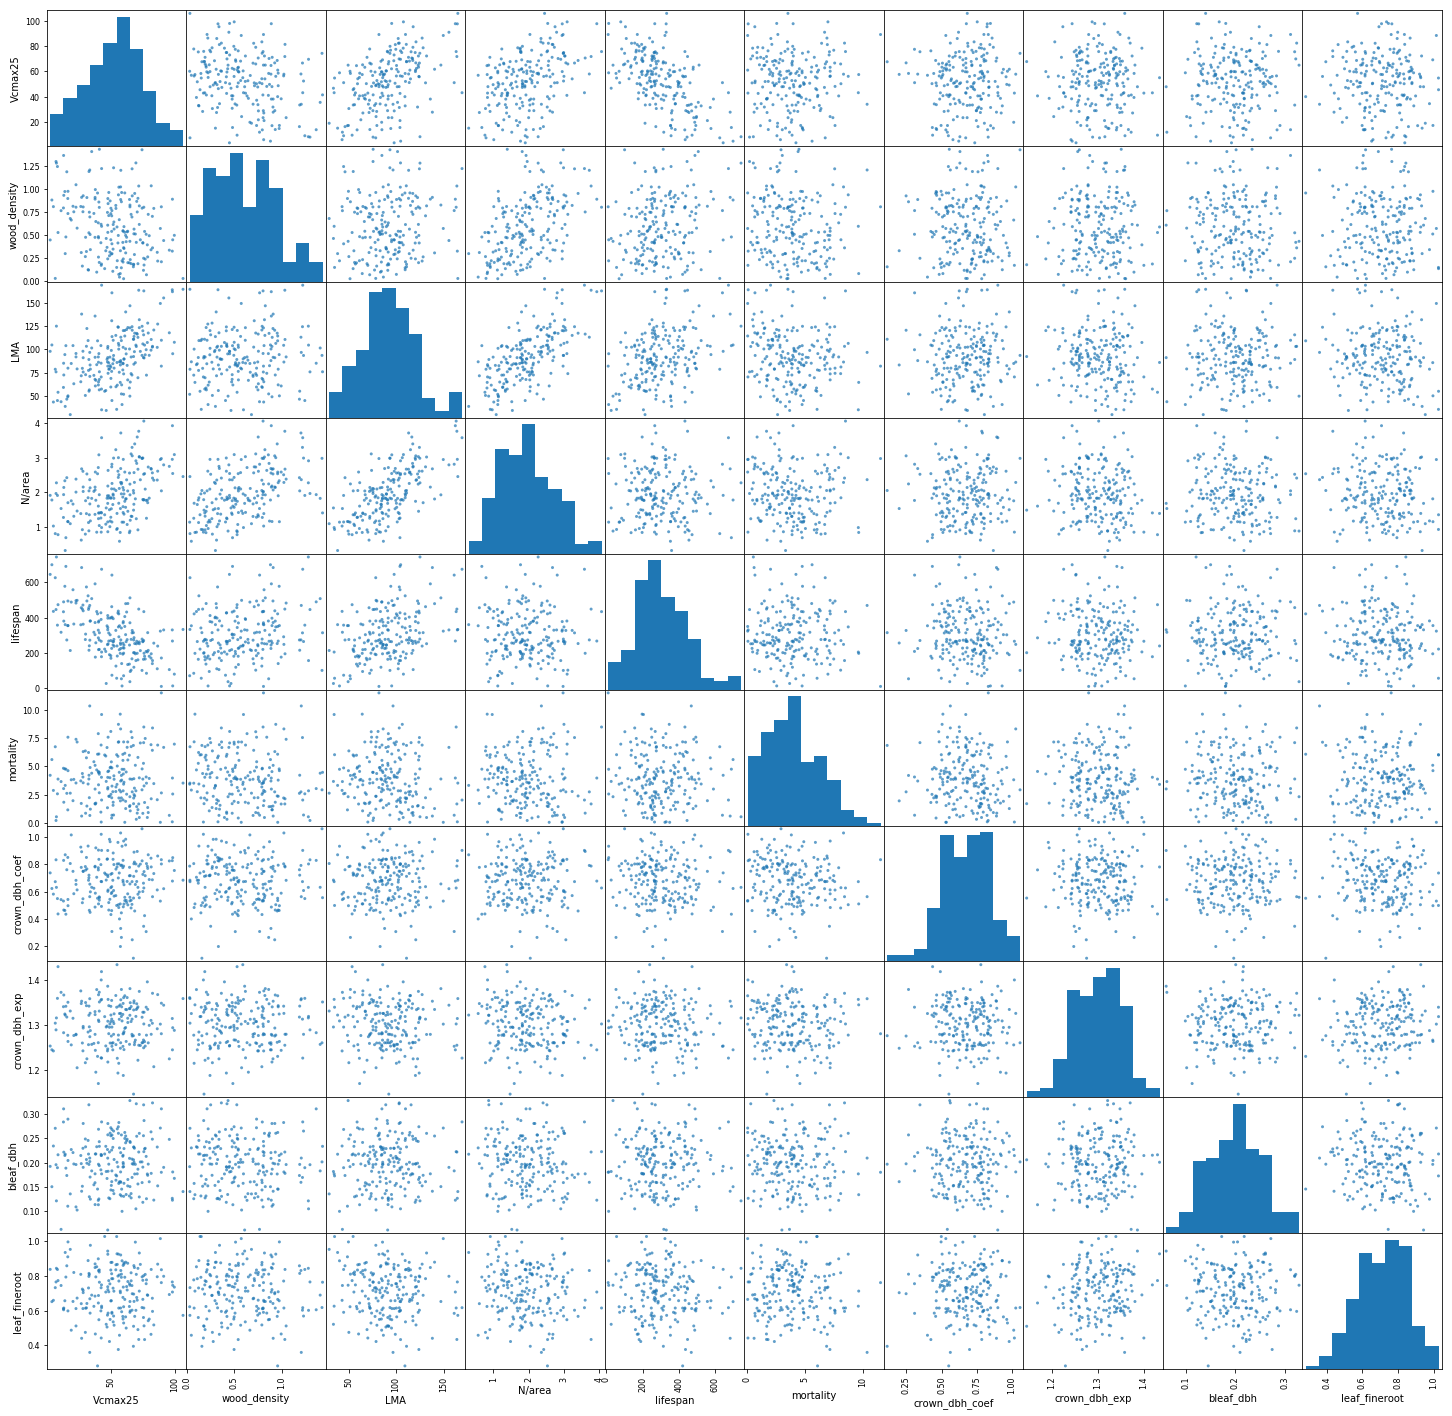

In [10]:
### now add a few other traits to the mix

### now we are using the mortality from the inventory data so won't make it up here,
#mortality_mean = 0.02
#mortality_variance = 0.005 ** 2
#mortality_indx = 5

### these distributions are all completely made up.
crown_to_dbh_coef_mean = 0.68431
crown_to_dbh_coef_variance = (crown_to_dbh_coef_mean * 0.25) **2
crown_to_dbh_coef_indx = 6

crown_to_dbh_exponent_mean = 1.3
crown_to_dbh_exponent_variance = (0.05)**2
crown_to_dbh_exponent_indx = 7

bleaf_to_dbh_mean = 0.2
bleaf_to_dbh_variance = (0.05)**2
bleaf_to_dbh_indx = 8

leaf_to_fineroot_mean = 0.7
leaf_to_fineroot_variance = (0.15)**2
leaf_to_fineroot_indx = 9

### for crown area parameters, martinez-cano et al show some correlation with wood density
### let crown area : DBH relationship be a function 
### of wood density following martinez-cano allometry
### CD = a DBH ^ b
### where b = 0.655 + 0.035 * z
### and log a = -0.268 + 0.186 * z
### when z is wood density
### for now we ignore these and impose the other traits as uncorrelated

ntraits_total = 10
full_trait_cov_matrix = np.zeros([ntraits_total,ntraits_total])
full_trait_cov_matrix[0:6,0:6] = trait_cov[:]

#full_trait_cov_matrix[mortality_indx,mortality_indx] = mortality_variance
full_trait_cov_matrix[crown_to_dbh_coef_indx,crown_to_dbh_coef_indx] = crown_to_dbh_coef_variance
full_trait_cov_matrix[crown_to_dbh_exponent_indx,crown_to_dbh_exponent_indx] = crown_to_dbh_exponent_variance
full_trait_cov_matrix[bleaf_to_dbh_indx,bleaf_to_dbh_indx] = bleaf_to_dbh_variance
full_trait_cov_matrix[leaf_to_fineroot_indx,leaf_to_fineroot_indx] = leaf_to_fineroot_variance

means_total = np.zeros(ntraits_total)
means_total[0:6] = means[:]

#means_total[mortality_indx] = mortality_mean
means_total[crown_to_dbh_coef_indx] = crown_to_dbh_coef_mean
means_total[crown_to_dbh_exponent_indx] = crown_to_dbh_exponent_mean
means_total[bleaf_to_dbh_indx] = bleaf_to_dbh_mean
means_total[leaf_to_fineroot_indx] = leaf_to_fineroot_mean

X_total = randomstate.multivariate_normal(means_total, np.array(full_trait_cov_matrix), n_out)
X_total_backup = randomstate.multivariate_normal(means_total, np.array(full_trait_cov_matrix), n_out)

### all of thes variables are positive definite.  go through them and check each row to make sure that all values
### in the row are positive.  if not, replace the entire row with one from a backup array
backup_copy = -1
for i in range(n_out):
    if X_total[i,:].min() <= 0:
        replacement_found = False
        backup_copy = backup_copy + 1
        while not replacement_found:
            if X_total_backup[backup_copy,:].min() > 0:
                replacement_found = True
            else:
                backup_copy = backup_copy + 1
        X_total[i,:] = X_total_backup[backup_copy,:]

df4 = pandas.DataFrame(X_total, columns=['Vcmax25', 'wood_density', 'LMA', 'N/area','lifespan','mortality','crown_dbh_coef','crown_dbh_exp','bleaf_dbh','leaf_fineroot'])
pandas.plotting.scatter_matrix(df4, alpha=0.7, figsize=(25, 25), diagonal='hist')

In [14]:
### now we want to write these new parameters to a set of fates netcdf parameter files
import netCDF4 as nc4
import sys
import os
import shutil

print(X_total.shape)

def copy_clobber(filename1, filename2):
    try:
        os.remove(filename2)
        print('replacing file: '+filename2)
    except:
        print('file does not yet exist: '+filename2)
    shutil.copyfile(filename1, filename2)

vcmax25_indx = 0
wood_density_indx = 1
lma_indx = 2
n_area_indx = 3
lifespan_indx = 4
mortality_indx = 5

carbon_fraction_mean = .4482  ## mean of leaf samples in norby dataset

#print(carbon_fraction_mean * X_total[:,lma_indx] / X_total[:,n_area_indx])  #sanity check for leafcn
#print(1./X_total[:,lma_indx]) #sanity check for lma
#print(X_total[:,lifespan_indx]/365.25) #sanity check for leaf lifespan
#sys.exit()

filename_template = 'fates_parameter_files/fates_params_default_c6ff126_mod.nc'
filename_output_basename = 'fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_'
for i in range(n_out):
    filename_out = filename_output_basename+str(i+1).zfill(4)+'.c180526.nc'
    copy_clobber(filename_template,filename_out)
    fin = nc4.Dataset(filename_out, 'r+')
    #
    vcmax25var = fin.variables['fates_leaf_vcmax25top']
    vcmax25var[:] = X_total[i,vcmax25_indx]
    #
    wood_density_var = fin.variables['fates_wood_density']
    wood_density_var[:] = X_total[i,wood_density_indx]
    #
    slatopvar = fin.variables['fates_leaf_slatop']
    slatopvar[:] = 1./X_total[i,lma_indx]
    #
    leafcnvar = fin.variables['fates_leaf_cn_ratio']
    leafcnvar[:] = carbon_fraction_mean * X_total[i,lma_indx] / X_total[i,n_area_indx]
    #
    leaflongvar = fin.variables['fates_leaf_long']
    leaflongvar[:] = X_total[i,lifespan_indx]/365.25
    #
    bmortvar = fin.variables['fates_mort_bmort']
    bmortvar[:] = X_total[i,mortality_indx]
    #
    crown_to_dbh_coef_var1 = fin.variables['fates_allom_d2ca_coefficient_min']
    crown_to_dbh_coef_var2 = fin.variables['fates_allom_d2ca_coefficient_max']
    crown_to_dbh_coef_var1[:] = X_total[i,crown_to_dbh_coef_indx]
    crown_to_dbh_coef_var2[:] = X_total[i,crown_to_dbh_coef_indx]
    #
    crown_to_dbh_exponent_var = fin.variables['fates_allom_d2bl2']
    crown_to_dbh_exponent_var[:] = X_total[i,crown_to_dbh_exponent_indx]
    #
    bleaf_to_dbh_var = fin.variables['fates_allom_d2bl1']
    bleaf_to_dbh_var[:] = X_total[i,bleaf_to_dbh_indx]
    #
    leaf_to_fineroot_var = fin.variables['fates_allom_l2fr']
    leaf_to_fineroot_var[:] = X_total[i,leaf_to_fineroot_indx]
    #
    fin.close()


(200, 10)
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0001.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0002.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0003.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0004.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0005.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0006.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0007.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0008.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0009.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6f

file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0108.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0109.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0110.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0111.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0112.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0113.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0114.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0115.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitraits_test01_v_0116.c180526.nc
file does not yet exist: fates_parameter_files/fates_params_c6ff126_bcitr

In [15]:
## write the raw sampled trait matrix out as a text file for easy analysis
## for now write out the whole set of traits

print(X_total.shape)
#files_used_start = 0
#files_used_end = n_out
#print(X_total[files_used_start:files_used_end].shape)
#np.savetxt('traits_matrix_used_in_param_files_240518.txt', X_total[files_used_start:files_used_end])
np.savetxt('traits_matrix_used_in_param_files_240518.txt', X_total)

(200, 10)
